[View in Colaboratory](https://colab.research.google.com/github/zhichengMLE/deep_learning/blob/master/COMS4995_HW1.ipynb)

In [5]:
import torch
torch.__version__


'0.3.0.post4'

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision
import torch.optim as optim
from numpy import float32

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [6]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
#testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


# Part 1

In [0]:
dataset_size = len(trainset)
train_ratio = 0.9
image_flatten_size = trainset[0][0].numpy().size
train_size = int(train_ratio * dataset_size)
valid_size = dataset_size - train_size


train_matrix = np.zeros((image_flatten_size,train_size), dtype = float32)
valid_matrix = np.zeros((image_flatten_size,valid_size), dtype = float32)
train_label  = np.zeros((train_size, len(classes)),dtype = float32)
valid_label  = np.zeros((valid_size, len(classes)),dtype = float32)

for i in range(train_size):
  temp = trainset[i][0].numpy().flatten()
  train_matrix[:,i] = temp
  train_label[i][trainset[i][1]] = 1 
for i in range(valid_size):
  temp = trainset[i+train_size][0].numpy().flatten()
  valid_matrix[:,i] = temp
  valid_label[i][trainset[i+train_size][1]] = 1 
  
  
train_matrix = train_matrix.T
valid_matrix = valid_matrix.T


In [137]:
print(train_label[9])
print(valid_label[9])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [61]:
print(np.amax(train_label))
print(np.amin(train_label))

9.0
0.0


In [0]:
class NeuralNetwork:
    def __init__(self, layer_dimensions):
        self.layer_dimensions = layer_dimensions
        self.parameters = {}
        for i in range(1, len(layer_dimensions)):
            self.parameters['W' + str(i)] = np.random.randn(layer_dimensions[i], layer_dimensions[i-1])
            self.parameters['b' + str(i)] = np.zeros((layer_dimensions[i], 1))
            
    def affineForward(self, A, W, b):
        Z = np.dot(W, A) + b
        return Z, (A, W, b)
        
    def activationForward(self, A, act_func='relu'):
        if(act_func == 'sigmoid'):
            return self.sigmoid(A)
        elif(act_func == 'tanh'):
            return self.tanh(A)
        elif(act_func == 'relu'):
            return self.relu(A)
            
    def forwardPropagation(self, X):
        A = X
        cache = []
        
        for i in range(1, len(self.layer_dimensions)):
            A_prev = A
            W = self.parameters['W' + str(i)]
            b = self.parameters['b' + str(i)]
            Z, af_cache = self.affineForward(A_prev, W, b)
            A = self.activationForward(Z, act_func='relu')
            
            
            cache.append(af_cache)
        return A, cache
    
    def costFunction(self, AL, y):
        print("ALShape",AL.shape,"Y Shape",y.shape)
        #cost = np.squeeze((-1 / AL.shape[1]) * (np.sum(np.log(AL) * y + np.log(1-AL) * (1-y))))
        cost = np.sum(np.log(AL).dot(y) + np.log(1-AL).dot(1-y))
        cost = np.squeeze((-1 / AL.shape[1]) * cost)
        
        #print('Cost: ', cost)
        
        dAL = -(np.divide(y, AL) - np.divide(1-y, 1-AL))
        
        return cost, dAL
        
    def affineBackward(self, dA_prev, cache):
        A_prev, W, b = cache
        
        m = A_prev.shape[1]
        
        dA = np.dot(W.T, dA_prev)
        dW = 1 / m * np.dot(dA_prev, A_prev.T)
        db = 1 / m * np.sum(dA_prev, axis=1, keepdims=True)
        
        return dA, dW, db
        
    def activationBackward(self, dA, cache, act_func='relu'):
        if(act_func == 'sigmoid'):
            return self.d_sigmoid(dA)
        elif(act_func == 'tanh'):
            return self.d_tanh(dA)
        elif(act_func == 'relu'):
            return self.d_relu(dA)
    
    def backPropagation(self, dAL, Y, cache):
        gradients = {}
        
        #for i in range(len(self.layer_dimensions)-1, 0, -1):
        for i in reversed(range(1, len(self.layer_dimensions))):
            lay_cache = cache[i-1]
            dZ = self.activationBackward(dAL, lay_cache, 'relu')
            dAL, dW, db = self.affineBackward(dZ, lay_cache)
            
            gradients['dW' + str(i)] = dW
            gradients['db' + str(i)] = db
            
        return gradients
        
    def updateParameters(self, gradients, alpha):
        for i in range(1, len(self.layer_dimensions)):
            dW = gradients['dW' + str(i)]
            db = gradients['db' + str(i)]
        
        
            self.parameters['W' + str(i)] = self.parameters['W' + str(i)] - alpha * dW
            self.parameters['b' + str(i)] = self.parameters['b' + str(i)] - alpha * db
        
    def train(self, X_train, X_val, y_train, y_val, iters, alpha, batch_size):
        counter = 0
        for i in range(iters):
           
            iter_cost = 0
            for j in range(math.ceil(len(X_train) / batch_size)):
                X_batch, y_batch = self.get_batch(X_train, y_train, j * batch_size, batch_size)
                y_pred, cache = self.forwardPropagation(X_batch.T)
                
                cost, dAL = self.costFunction(y_pred, y_batch)
                gradients = self.backPropagation(dAL, y_batch, cache)
               
                self.updateParameters(gradients, alpha)
                iter_cost += cost # @TODO might be wrong since average in costFunction
                
                
            y_pred_val = self.predict(X_val.T)
            val_cost, _ = self.costFunction(y_pred_val, y_val)
            print('%d / %d' %(i+1, iters))
            print('train cost : ', iter_cost / math.ceil(len(X_train) / batch_size))
            print('validation cost : ', val_cost)
            
            
    def get_batch(self, X, y, start_idx, batch_size):
        end_idx = start_idx + batch_size
        if(end_idx > len(X) - 1):
            end_idx = len(X) - 1
        return X[start_idx:end_idx, :], y[start_idx:end_idx, :]
        
    def predict(self, X_new):
        y_pred, cache = self.forwardPropagation(X_new)
        return y_pred
    
    def sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        return A
   
    def tanh(self, Z):
        return np.tanh(Z)
   
    def relu(self, Z):
        A = np.maximum(0, Z)
        return A
    
    def d_sigmoid(self, Z):
        return Z * (1.0 - Z)

    def d_tanh(self, Z):
        return 1.0 - np.tanh(Z) ** 2
    
    def d_relu(self, Z):
        Z[Z >= 0] = 1
        Z[Z < 0 ] = 0
        return Z

In [147]:
layer_dimensions = [train_matrix.shape[1], 5, 10]
dnn = NeuralNetwork(layer_dimensions)
dnn.train(train_matrix, valid_matrix, train_label, valid_label, iters=10, alpha=0.01, batch_size=1000)

ALShape (10, 1000) Y Shape (1000, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log


ValueError: ignored

In [45]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

6


NameError: ignored

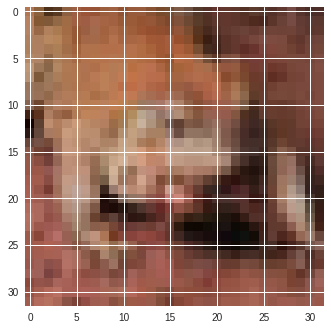

In [44]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(testset[5][0]) # displays test image number 5
print(testset[5][1]) # displays test image number 5
print(dnn.predict(testset[5][0]))


# Part 2

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

TypeError: ignored

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))